# **Proyecto 2: Datascience** 
## <span style="color:orange"> **Ingeniería de features, modelos avanzados e interpretación de modelos** </span>

 **Properati** 
 
Importando e inspeccionando el dataset.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_prop = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
print(data_prop.shape)
data_prop.head()

(146660, 19)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


<span style="color:orange"> A - **Ingeniería de features** </span>

**Limpieza del dataset:** Reviso columnas con valores únicos y sin correlación con la variable a predecir y las borro. Ejemplo: en la columna 'currency' el único valor existente es 'USD', lo mismo ocurre en 'operation_type'. También hay variables categóricas que en esta fase aún no alcanzamos a aprovechar (como 'description'o 'title'). Reduzco las columnas de 19 a 9. 

In [3]:
data_prop.drop(['created_on','l1','currency','title','description','operation_type','lat', 'lon', 'start_date', 'end_date'], 
               axis=1, inplace = True)

In [4]:
print(data_prop.shape)

(146660, 9)



**Valores Faltantes**

Reviso los valores faltantes del nuevo set de datos. Solo imprimo aquellas que tienen valores faltantes diferente a 0. 

In [5]:
miss_values_count = data_prop.isnull().sum(min_count=1)
miss_values_count = miss_values_count[miss_values_count != 0]
print(miss_values_count)

bathrooms           5957
surface_total      20527
surface_covered    21614
dtype: int64


Comienzo analizando el atributo baños ya que en el Proyecto 1 vimos que tenía una correlación alta con el precio. 

In [6]:
data_vf = data_prop.property_type[(data_prop.bathrooms.isnull())].groupby([data_prop.property_type]).size().reset_index(name='Valores_NA')
data_vf['Valores_no_NA'] = data_prop.property_type[(data_prop.bathrooms.isnull()==False )].groupby([data_prop.property_type]).size().reset_index(name='Valores_NA').iloc[:,1]

data_vf['% faltantes'] = data_vf['Valores_NA'] / (data_vf['Valores_no_NA']+data_vf['Valores_NA'])*100
data_vf['% NO_faltantes'] = 100 - data_vf['% faltantes'] 
data_vf

,property_type,Valores_NA,Valores_no_NA,% faltantes,% NO_faltantes
0,Casa,1337,20184,6.212537,93.787463
1,Casa de campo,21,301,6.521739,93.478261
2,Cochera,250,9,96.525097,3.474903
3,Departamento,2696,104630,2.511973,97.488027
4,Depósito,229,36,86.415094,13.584906
5,Local comercial,171,154,52.615385,47.384615
6,Lote,835,477,63.643293,36.356707
7,Oficina,112,546,17.021277,82.978723
8,Otro,128,246,34.224599,65.775401
9,PH,178,14120,1.244929,98.755071


Con la fórmula anterior visualizo la relación entre cantidad de valores faltantes en la columna 'bathrooms' y cada tipo de propiedad. Observo que se ubican cerca de 0 algunos tipos como Depósitos o Cocheras. Repitiendo este análisis con las columnas 'surface_covered' y 'surface_total' ocurre lo mismo.

Es decir que los valores faltantes en la categoría baños son MAR (la probabilidad de que ese valor falte depende de otra variable incluida en el set de datos, en este caso el tipo de propiedad).

Porcentualmente en los tipos de propiedad principales la cantidad de faltantes es menos de 1 dígito. Y en muchos de los tipos de propiedad menos numerosos la indicación de baño existe pero es 0. **La decisión será imputar esas instancias en todos los tipos de propiedad con el valor del promedio en cada caso.**

Borro las instancias que dentro de la variable 'property_type' tiene el valor 'Otro'.

In [7]:
data_prop.drop(data_prop.loc[data_prop['property_type'] == 'Otro'].index, inplace=True)

In [8]:
print(data_prop.shape)

(146286, 9)


Calculo el promedio de los valores existentes en cada categoría con faltantes:

In [9]:
prom_bath = data_prop['bathrooms'].mean()
print(prom_bath)

1.5989591120414077


In [10]:
prom_sup_total = data_prop['surface_total'].mean()
print(prom_sup_total)

202.83749890797614


In [11]:
prom_sup_cub = data_prop['surface_covered'].mean()
print(prom_sup_cub)

112.73828790971305


Reemplazo los valores NaN o faltantes con el promedio calculado arriba. 

In [12]:
data_prop["bathrooms"].replace(np.nan, prom_bath, inplace = True )

In [13]:
data_prop["surface_covered"].replace(np.nan, prom_sup_cub, inplace = True)

In [14]:
data_prop["surface_total"].replace(np.nan, prom_sup_total, inplace = True)

Confirmo que ya no quedan datos faltantes

In [15]:
miss_values_count = data_prop.isnull().sum(min_count=1)
miss_values_count = miss_values_count[miss_values_count != 0]
print(miss_values_count)

Series([], dtype: int64)


**Outliers**

Realizo un análisis de outliers, para evaluar si es conveniente conservar todos los tipos de propiedad. Inicio con una descripción de las variables numéricas del dataset. 

In [16]:
data_prop.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,146286.000000,146286.000000,146286.000000,146286.000000,146286.000000,1.462860e+05
mean,3.077868,1.981926,1.598959,202.837499,112.738288,2.401205e+05
std,1.412966,1.148353,0.870274,1613.918434,847.659193,3.029039e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,2.000000,1.000000,1.000000,55.000000,50.000000,1.110000e+05
50%,3.000000,2.000000,1.000000,90.000000,77.000000,1.659230e+05
75%,4.000000,3.000000,2.000000,202.837499,112.738288,2.650000e+05
max,35.000000,15.000000,14.000000,169000.000000,126062.000000,3.243423e+07


Mediante un diagrama de cajas o boxplot analizo la extensión de las variables numéricas principales en relación a los tipos de propiedad.

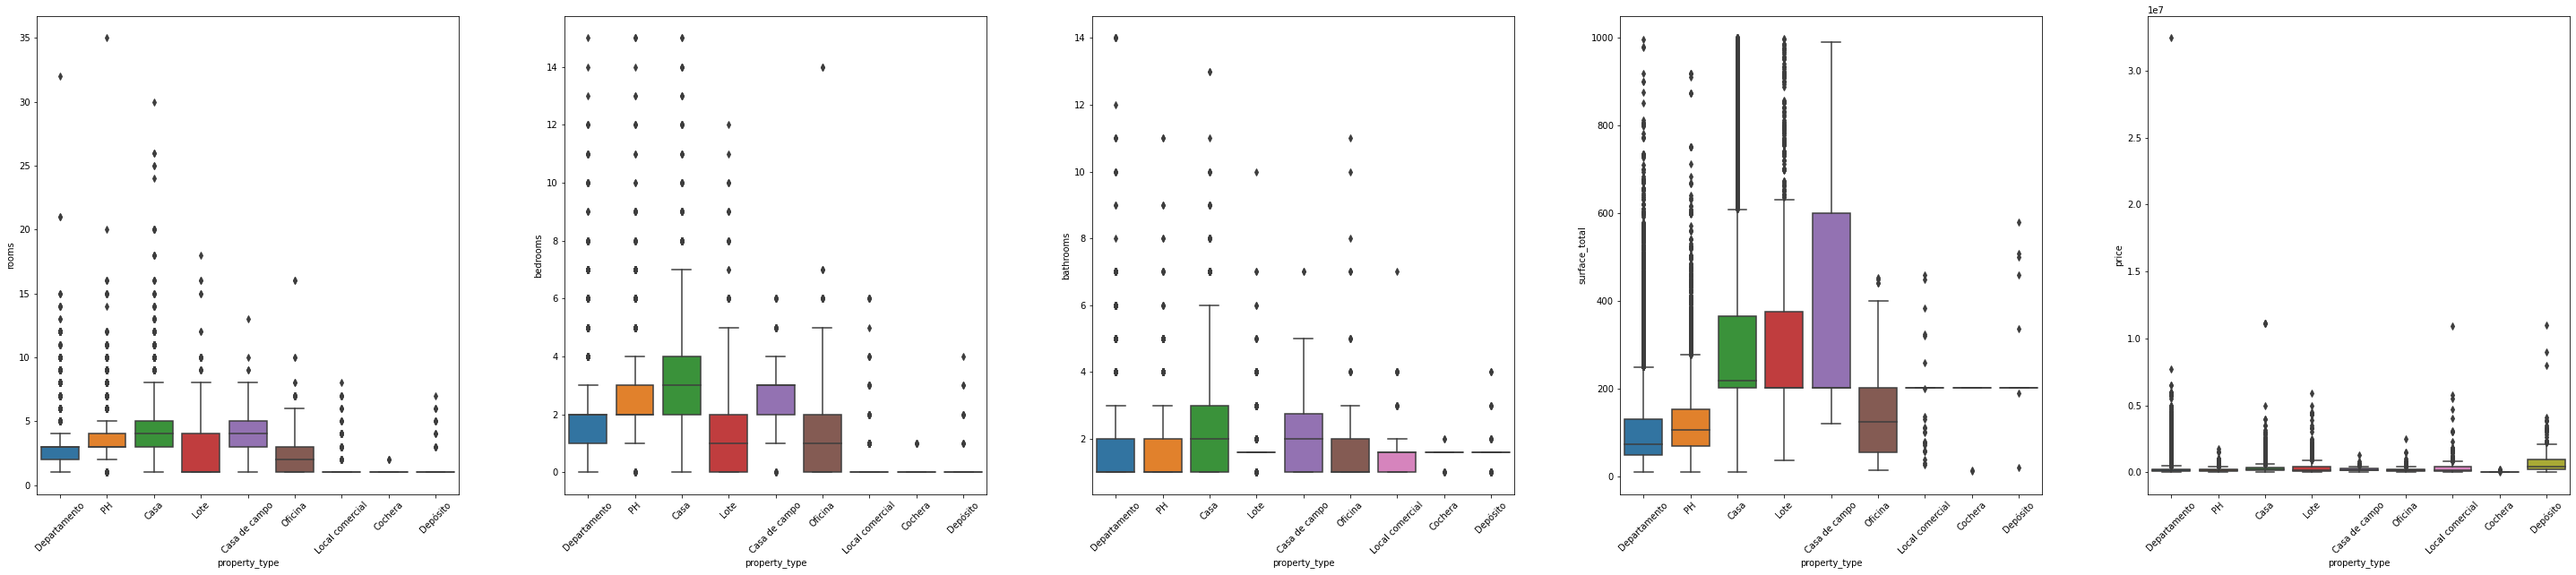

In [17]:
plt.figure(figsize=(40,8))
plt.grid()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.25)

plt.subplot(1,5,1)
plt.xticks(rotation = 45)
sns.boxplot(y = data_prop['rooms'], x = data_prop['property_type'], data = data_prop)

plt.subplot(1,5,2)
plt.xticks(rotation = 45)
sns.boxplot(y = data_prop['bedrooms'], x = data_prop['property_type'], data = data_prop)

plt.subplot(1,5,3)
plt.xticks(rotation = 45)
sns.boxplot(y = data_prop['bathrooms'], x = data_prop['property_type'], data = data_prop)

plt.subplot(1,5,4)
plt.xticks(rotation = 45)
sns.boxplot(y = data_prop['surface_total'], x = data_prop['property_type'][data_prop['surface_total']<1000])

plt.subplot(1,5,5)
plt.xticks(rotation = 45)
sns.boxplot(y = data_prop['price'], x = data_prop['property_type'], data = data_prop)

plt.show()

En la elección de los límites de outliers, me guío con la información del boxplot, pero además sumo mi intuición y lo que conozco del mercado inmobiliario. Realizo una máscara para cada variable numérica que me interesa limpiar, determinando su valor máximo. 

In [18]:
mask_rooms = data_prop.rooms <= 5

In [19]:
mask_bedrooms = data_prop.bedrooms <= 4

In [20]:
mask_bathrooms = data_prop.bathrooms <= 3

Para evitar errores de variables de superficie con valor 0 (no es nulo sino erróneo) seteo el mínimo. De esta forma no dejo afuera variables que pueden considerarse un outlier de tipo de propiedad (como oficinas o locales) pero que me interesa mantener para la funcionalidad que pretendo darle al modelo final.

In [21]:
mask_sup = np.logical_and(data_prop.surface_total<=1000, data_prop.surface_total>=0)

In [22]:
mask_price = data_prop.price <= 1000000

In [24]:
data_prop_1 = data_prop[mask_sup&mask_price&mask_rooms&mask_bedrooms&mask_bathrooms]
data_prop_1.shape

(133086, 9)

El dataset resulta reducido en sus instancias en un 9%. Es un dataset extenso si lo comparamos con el del Proyecto 1, pero por los tipos de datasets que utilizo diariamente en mi trabajo me interesa también probar como Python mejora el tratamiento de grandes volúmenes de información. 

**Escalado de Datos**

Realizo una normalización de datos incluidos en el dataset. Esto en virtud que las columnas con valores numéricos utilizan diferentes tipos de unidades de medida (por ejemplo rooms o bathrooms utilizan unidades, mientras que superficie utiliza metros, se puede ver esta diferencia entre valores además en su desviación standard). 

Mediante StandardScaler se estandarizan las variables eliminando la media y escalando a la varianza de la unidad.



In [25]:
data_prop_1.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,133086.000000,133086.000000,133086.000000,133086.000000,133086.000000,133086.000000
mean,2.826616,1.810604,1.443010,120.784608,87.077480,194642.514104
std,1.056165,0.942563,0.621312,111.403775,347.538718,132528.221582
min,1.000000,0.000000,1.000000,10.000000,1.000000,5500.000000
25%,2.000000,1.000000,1.000000,53.000000,48.000000,109000.000000
50%,3.000000,2.000000,1.000000,82.000000,71.000000,158000.000000
75%,4.000000,2.000000,2.000000,171.000000,112.738288,240000.000000
max,5.000000,4.000000,3.000000,1000.000000,90183.000000,1000000.000000


In [26]:
from sklearn.preprocessing import StandardScaler
X_aux = data_prop_1.iloc[:, 2:7] 
scl = StandardScaler()
X_aux = scl.fit_transform(X_aux)
for i in range(2,7):
    data_prop_1.iloc[:, i] = X_aux[:, i-2]

C:\Users\cti22275\Miniconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
data_prop_1.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
1,Capital Federal,Boedo,-0.782661,-0.860003,0.896478,-0.455862,-0.083667,159000.0,PH
2,Capital Federal,Palermo,-0.782661,-0.860003,-0.713027,-0.680272,-0.121073,125000.0,PH
3,Capital Federal,Palermo,-0.782661,-0.860003,-0.713027,-0.321217,-0.106686,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,-0.782661,-0.860003,-0.713027,-0.635390,-0.149847,40000.0,PH
5,Capital Federal,Villa Crespo,-0.782661,-0.860003,-0.713027,-0.581532,-0.089422,150000.0,PH


Revisando nuevamente la descripción del dataset modificado podemos ver el resultado de la estandarización en la varianza (std = 1).

In [28]:
data_prop_1.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,1.330860e+05,1.330860e+05,1.330860e+05,1.330860e+05,1.330860e+05,133086.000000
mean,1.966878e-16,-3.331520e-17,9.054900e-16,9.482018e-17,2.359827e-17,194642.514104
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,132528.221582
min,-1.729487e+00,-1.920943e+00,-7.130267e-01,-9.944459e-01,-2.476783e-01,5500.000000
25%,-7.826611e-01,-8.600026e-01,-7.130267e-01,-6.084611e-01,-1.124411e-01,109000.000000
50%,1.641645e-01,2.009383e-01,-7.130267e-01,-3.481458e-01,-4.626115e-02,158000.000000
75%,1.110990e+00,2.009383e-01,8.964777e-01,4.507530e-01,7.383610e-02,240000.000000
max,2.057816e+00,2.322820e+00,2.505982e+00,7.892180e+00,2.592409e+02,1000000.000000


**Encoding:** Convierto los atributos categóricos 'property_type', 'l2' y 'l3' en valores numéricos. En el Proyecto 1 no usábamos esta información como variable, sino únicamente en la fase exploratoria del conjunto de datos, o particularmente property_type como delimitante de los datos. 

In [29]:
property_type_dummy = pd.get_dummies(data_prop_1['property_type'], prefix = 'property_type')
l2_dummy = pd.get_dummies(data_prop_1['l2'], prefix = 'l2')
l3_dummy = pd.get_dummies(data_prop_1['l3'], prefix = 'l3')

In [30]:
data_prop_1 = pd.concat([data_prop_1, property_type_dummy], axis=1)
data_prop_1 = pd.concat([data_prop_1, l2_dummy], axis=1)
data_prop_1 = pd.concat([data_prop_1, l3_dummy], axis=1)

In [31]:
data_prop_1.shape

(133086, 111)

In [32]:
data_prop_1.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,property_type_Casa,...,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
1,Capital Federal,Boedo,-0.782661,-0.860003,0.896478,-0.455862,-0.083667,159000.0,PH,0,...,0,0,0,0,0,0,0,0,0,0
2,Capital Federal,Palermo,-0.782661,-0.860003,-0.713027,-0.680272,-0.121073,125000.0,PH,0,...,0,0,0,0,0,0,0,0,0,0
3,Capital Federal,Palermo,-0.782661,-0.860003,-0.713027,-0.321217,-0.106686,295000.0,PH,0,...,0,0,0,0,0,0,0,0,0,0
4,Bs.As. G.B.A. Zona Sur,La Plata,-0.782661,-0.860003,-0.713027,-0.635390,-0.149847,40000.0,PH,0,...,0,0,0,0,0,0,0,0,0,0
5,Capital Federal,Villa Crespo,-0.782661,-0.860003,-0.713027,-0.581532,-0.089422,150000.0,PH,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Borro las columnas con tipo de dato string

data_prop_1.drop(['property_type', 'l2', 'l3'], 
               axis=1, inplace = True)

In [ ]:
data_prop_1.shape

Resulta un dataset de 108 columnas.

II - **Re entrenamiento de los modelos del Proyecto 1** 

Tomo las mismas variables que utilicé en el Proyecto 1, pero ya en el nuevo dataset resultante del preprocesamiento, y previo a la reducción de dimensionalidad.

In [35]:
x1 = data_prop_1.surface_total
x2 = data_prop_1.bathrooms
y =  data_prop_1.price

Grafico los datos en 3 dimensiones y ya puedo notar la diferencia en la estructura de los datos respecto del modelo 1, gracias al escalado. 

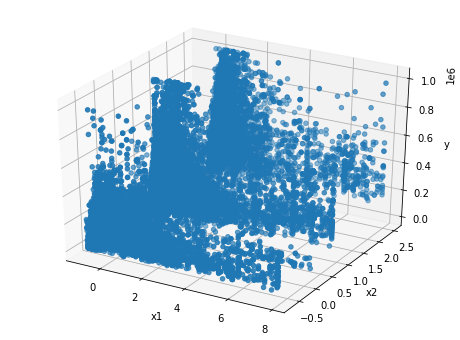

In [36]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(x1, x2, y, ax=None, fig = None):
    if (fig is None) and (ax is None):
        fig = plt.figure(figsize = (8,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, y)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')

plot_3d_scatter(x1, x2, y, ax=None, fig = None)

Entreno los modelos de regresión usados en el Proyecto 1 con este nuevo Data Frame.

In [37]:
#Train, Test, Split
from sklearn.model_selection import train_test_split

X = np.vstack((x1,x2)).T

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(106468, 2) (106468,) (26618, 2) (26618,)


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

linear_model = LinearRegression()
tree_regressor = DecisionTreeRegressor(max_depth= 5, random_state=42)
knn_regressor = KNeighborsRegressor(n_neighbors=6)

In [39]:
linear_model.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=6)

In [40]:
print(linear_model.coef_, linear_model.intercept_)
print(linear_model.score(X_train, y_train))

[ 7810.42543149 75910.03494322] 194585.84945368415
0.35371442617294957


In [41]:
from matplotlib import cm

def plot_3d_regressor(x1_min, x1_max, x2_min,x2_max, N, regressor, ax=None, fig = None):
    x1 = np.linspace(x1_min,x1_max,N) 
    x2 = np.linspace(x2_min,x2_max,N)
    X1, X2 = np.meshgrid(x1,x2)
    
    y = regressor.predict(np.array([X1.ravel(), X2.ravel()]).T)
    Y = y.reshape(X1.shape)
    
    if (fig is None) and (ax is None):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X1, X2, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

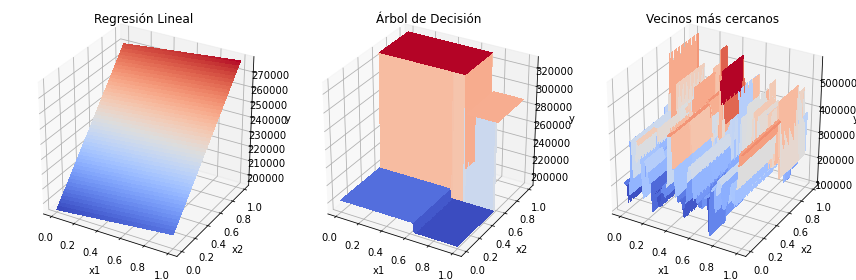

In [42]:
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(131, projection='3d')
plt.title('Regresión Lineal')
plot_3d_regressor(0, 1, 0, 1, 100, linear_model, ax, fig)
plot_3d_scatter(x1, x2, y, ax, fig)


ax = fig.add_subplot(132, projection='3d')
plt.title('Árbol de Decisión')
plot_3d_regressor(0, 1, 0, 1, 100, tree_regressor, ax, fig)
plot_3d_scatter(x1, x2, y, ax, fig)

ax = fig.add_subplot(133, projection='3d')
plt.title('Vecinos más cercanos')
plot_3d_regressor(0, 1, 0, 1, 100, knn_regressor, ax, fig)
plot_3d_scatter(x1, x2, y, ax, fig)

plt.tight_layout()
plt.show()

En la proyección 3D de los modelos entrenados ya es posible ver que no hay relación lineal natural entre las variables elegidas, por lo que al momento de evaluar los modelos los resultados no serán los mejores.

Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 106279.81627984886
Raíz del error cuadrático medio en Test: 107402.25981603857
R2 score Train : 0.35
R2 score Test : 0.36


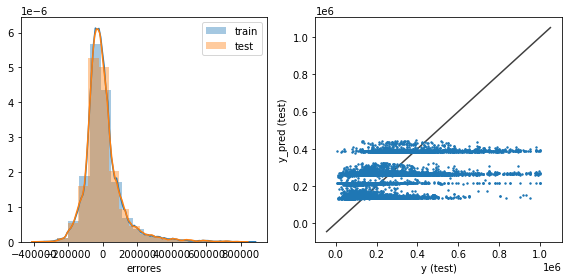

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 98062.58247828962
Raíz del error cuadrático medio en Test: 98949.23391068813
R2 score Train : 0.45
R2 score Test : 0.45


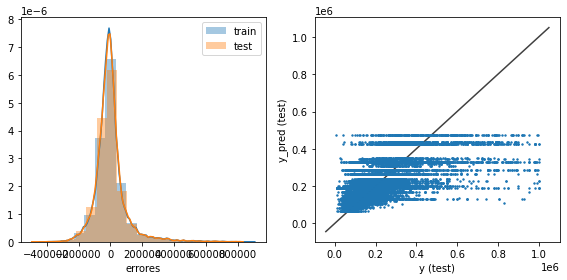

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 98721.02379009113
Raíz del error cuadrático medio en Test: 102104.33273474255
R2 score Train : 0.44
R2 score Test : 0.42


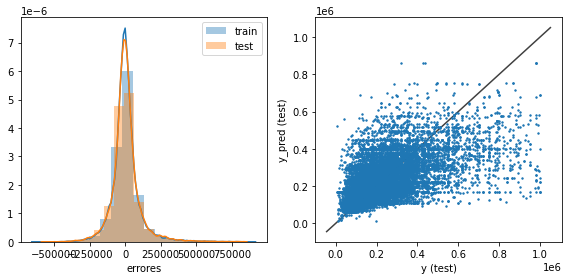

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
modelos = ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([linear_model, tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print("R2 score Train : %.2f" % r2_score(y_train,y_train_pred))
    print("R2 score Test : %.2f" % r2_score(y_test,y_test_pred))
       
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

Los resultados son más alejados a la línea de regresión que en el Proyecto 1. Era esperable ya que entre otras decisiones preferí ampliar al alcance del dataset incorporando tipos de propiedad que en el primer proyecto no incorporé.

**Reducción de Dimensionalidad** - PCA 

Busco reducir la cantidad de features de mi dataset, pero conservando la mayor cantidad de información posible. Utilizo PCA ya que realiza una reducción lineal. 

Como paso previo a la reducción de dimensionalidad quito la columna a predecir con los modelos ('price').

In [44]:
data_prop_noprice = data_prop_1.drop(data_prop_1.columns[[5]], axis=1)
data_prop_noprice.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,property_type_Depósito,...,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
1,-0.782661,-0.860003,0.896478,-0.455862,-0.083667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.782661,-0.860003,-0.713027,-0.680272,-0.121073,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.782661,-0.860003,-0.713027,-0.321217,-0.106686,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.782661,-0.860003,-0.713027,-0.635390,-0.149847,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.782661,-0.860003,-0.713027,-0.581532,-0.089422,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Realizo un primer entrenamiento con 2 componentes para obtener la varianza explicada acumulada y luego poder graficar la progresión de este indicador a medida que aumentan los números de componentes. 

La elección será de aquellas opciones de números de componentes (n_components) cuya explained_variance_ratio sea más cercana a 1. 

In [45]:
from sklearn.decomposition import PCA

X = data_prop_noprice


pca = PCA(n_components=2)
data_prop_nuevo = pca.fit_transform(X) 

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.37657325 0.14560674]
[588.04111011 365.65683124]


Text(0, 0.5, 'Varianza Explicada Acumulada')

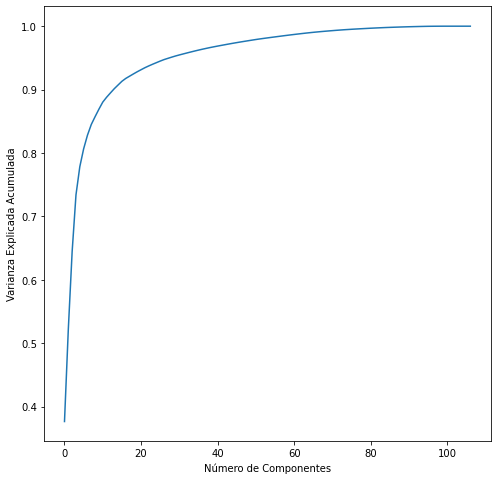

In [46]:
plt.figure(figsize = (8,8))
plt.xscale('linear')
pca = PCA().fit(data_prop_noprice)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')

In [47]:
pca_2 = PCA(n_components=75)
data_prop_pca_1 = pca_2.fit_transform(X) 

#print(pca_2.explained_variance_ratio_)
#print(pca_2.singular_values_)
pca_2.components_

array([[ 5.67982986e-01,  5.51285961e-01,  4.44444166e-01, ...,
         1.52537158e-04, -4.20049653e-03, -8.92585087e-04],
       [-1.40007791e-01, -1.75386684e-01, -8.47797814e-02, ...,
         2.09064702e-04, -2.07209564e-03, -1.16124707e-03],
       [ 1.91820755e-01,  2.80436604e-01,  8.53856031e-02, ...,
         1.34498887e-04,  6.65833305e-03,  3.02313941e-03],
       ...,
       [-6.70177211e-04, -1.29817687e-04,  1.56772984e-03, ...,
        -6.29440951e-04,  4.04022090e-04,  1.51054409e-03],
       [-3.26078639e-04,  1.33458624e-03, -3.62610292e-04, ...,
         1.80312806e-03, -1.26521683e-02, -1.57387768e-02],
       [ 8.35081479e-03, -1.14276773e-03, -3.57451095e-03, ...,
         7.00312300e-04, -2.88407980e-03, -2.66447035e-03]])

In [48]:
data_prop_pca_1 = pd.DataFrame(data_prop_pca_1)
data_prop_pca_1.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,-0.633668,-0.021704,0.019134,1.132306,0.077506,-1.217204,-0.821049,-0.241242,-0.019480,-0.159249,...,-0.020907,-0.002683,-0.016727,-0.018407,-0.014850,-0.002043,-0.003092,0.003449,-0.014208,-0.018494
1,-1.444441,0.005502,0.082925,-0.243769,0.174871,-1.019426,-0.785478,-0.346298,-0.295806,0.764436,...,-0.000652,0.001883,0.005319,-0.006871,-0.003746,0.001939,0.004026,-0.000518,-0.006041,-0.009951
2,-1.307474,0.116070,-0.190696,-0.258308,0.298796,-0.950162,-0.796400,-0.353220,-0.295465,0.754422,...,-0.000640,0.001552,0.005810,-0.006721,-0.003831,0.001697,0.004153,-0.000707,-0.006167,-0.010926
3,-1.362197,0.137567,-0.363692,-0.331118,-0.849588,-1.275773,0.056067,-0.407258,0.607920,0.041402,...,0.000670,0.000559,0.005937,-0.002634,-0.003165,0.000990,0.002874,0.003291,-0.004065,-0.008957
4,-1.404815,0.068622,-0.004188,-0.272482,0.139468,-1.003087,-0.791800,-0.324287,-0.048167,-0.260287,...,-0.001156,0.001697,0.005363,-0.006887,-0.003932,0.001698,0.003462,-0.000272,-0.006086,-0.014489


Realizo un Train, Test, Split con los nuevos datos reducidos mediante PCA y entreno los modelos del Proyecto 1.

In [49]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_prop_pca_1, y, test_size=0.33, random_state=42)

In [50]:
linear_model_pca = LinearRegression()
tree_regressor_pca = DecisionTreeRegressor(max_depth= 5, random_state=42)
knn_regressor_pca = KNeighborsRegressor(n_neighbors=6)

In [51]:
linear_model_pca.fit(X_train_2, y_train_2)
tree_regressor_pca.fit(X_train_2, y_train_2)
knn_regressor_pca.fit(X_train_2, y_train_2)

KNeighborsRegressor(n_neighbors=6)

In [52]:
#print(linear_model_pca.coef_, linear_model_pca.intercept_)
print(linear_model_pca.score(X_train_2, y_train_2))

0.5774491493510601


Modelo: Regresión lineal
Raíz del error cuadrático medio en Train PCA: 85762.84086902344
Raíz del error cuadrático medio en Test PCA: 86543.38911493492
R2 score Train PCA : 0.58
R2 score Test PCA : 0.58


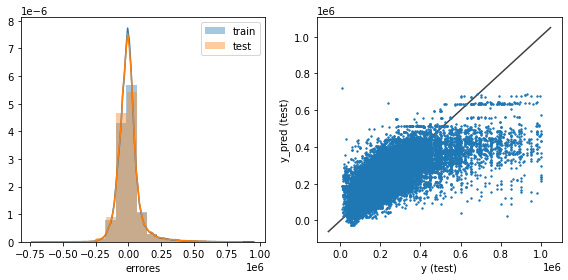

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train PCA: 89176.92163351043
Raíz del error cuadrático medio en Test PCA: 90241.53741209893
R2 score Train PCA : 0.54
R2 score Test PCA : 0.54


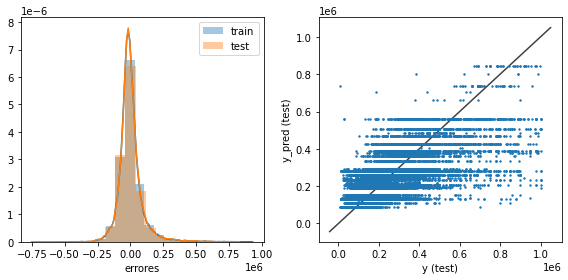

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train PCA: 55780.48813173717
Raíz del error cuadrático medio en Test PCA: 64662.436147859844
R2 score Train PCA : 0.82
R2 score Test PCA : 0.77


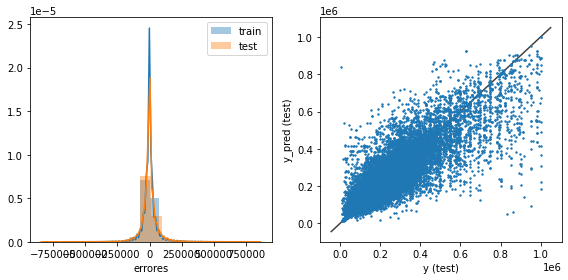

In [53]:
modelos = ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([linear_model_pca, tree_regressor_pca, knn_regressor_pca]):
    y_train_pred_2 = model.predict(X_train_2)
    y_test_pred_2 = model.predict(X_test_2)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train_2 = np.sqrt(mean_squared_error(y_train_2, y_train_pred_2))
    rmse_test_2 = np.sqrt(mean_squared_error(y_test_2, y_test_pred_2))
    print(f'Raíz del error cuadrático medio en Train PCA: {rmse_train_2}')
    print(f'Raíz del error cuadrático medio en Test PCA: {rmse_test_2}')
    print("R2 score Train PCA : %.2f" % r2_score(y_train_2,y_train_pred_2))
    print("R2 score Test PCA : %.2f" % r2_score(y_test_2,y_test_pred_2))
       
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train_2 - y_train_pred_2, bins = 20, label = 'train')
    sns.distplot(y_test_2 - y_test_pred_2, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test_2,y_test_pred_2, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

Todos los modelos mejoran respecto del entrenamiento previo a la reducción de dimensionalidad. Particularmente en el modelo de regresión lineal y vecinos más cercanos. En esta instancia me cuestiono si con el R2 score alcanzado en el árbol de decisión debo volver a revisar el preprocesamiento o ver si ese número es bueno para trabajar con modelos avanzados. Elijo continuar y de ser necesario revisarlo en una siguiente fase.

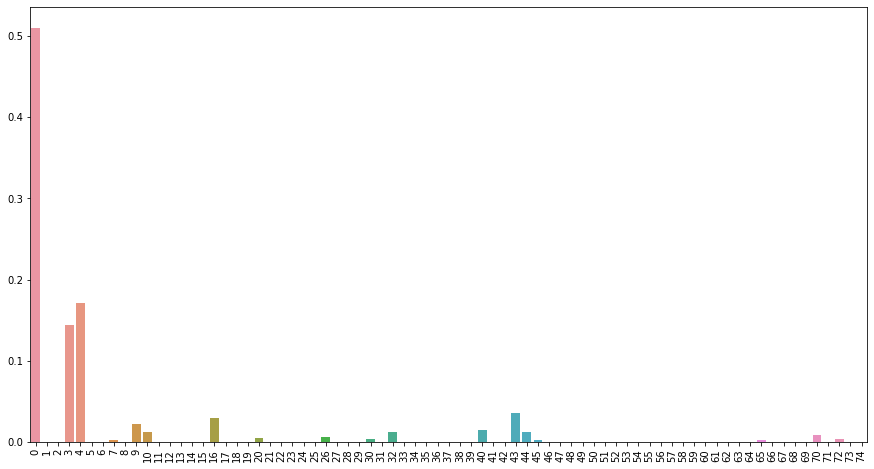

In [54]:
importances_tree = tree_regressor_pca.feature_importances_
columns = X_train_2.columns
#indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
plt.xticks(rotation = 90)
sns.barplot(columns, importances_tree)
plt.show()

Realicé el entrenamiento del modelo Random Forest Regressor tanto con el Data Frame con reducción de dimensionalidad (PCA) como solo habiendo completado el paso de escalado de los datos (Standardscaler).

En ambos casos el R2 score en train se ubicó en torno al 0.75. Por lo cual decido realizar el entrenamiento del Random Forest Regressor con el dataset escalado, sin reducción de dimensionalidad con PCA. 

Entre otras ventajas encuentro mejor entendimiento sobre los features que participan en la predicción del precio (ya que en PCA se convierten en nuevas variables innombradas categoricamente). Aunque menos variedad respecto de los features considerados (ver gráfico importances_tree anterior).

De todas formas si comparo los resultados obtenidos con los modelos del Proyecto 1 e incluso con los modelos sin ensamble utilizados con este dataset preprocesado los resultados son mejores que en el Random Forest previo a optimizar los hiperparámetros. 

<span style="color:orange"> B - **Modelos Avanzados** </span>

<span style="color:orange"> RANDOM FOREST REGRESSOR </span>


In [55]:
from sklearn.ensemble import RandomForestRegressor


In [56]:
X_rf = data_prop_noprice
y_rf = data_prop_1.price

**Entrenamiento del Random Forest Regressor**

In [57]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split (X_rf, y_rf, test_size = 0.05)

In [58]:
properati_rf = RandomForestRegressor(max_depth=2, random_state=0)
properati_rf.fit(X_train_rf,y_train_rf)

RandomForestRegressor(max_depth=2, random_state=0)

In [59]:
y_test_pred_rf = properati_rf.predict (X_test_rf)
y_train_pred_rf = properati_rf.predict (X_train_rf)

Mido el desempeño del modelo.

Raíz del error cuadrático medio en Train: 103854.04456038513
Raíz del error cuadrático medio en Test: 105885.34425073623
R2 score Train Random Forest Regressor: 0.38
R2 score Test Random Forest Regressor : 0.39


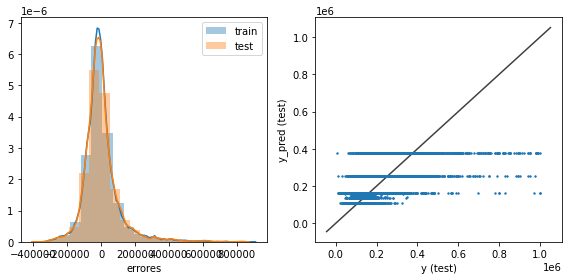

In [60]:
from sklearn.metrics import mean_squared_error

rmse_train_rf = np.sqrt(mean_squared_error(y_train_rf, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test_rf, y_test_pred_rf))
print(f'Raíz del error cuadrático medio en Train: {rmse_train_rf}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_rf}')
print("R2 score Train Random Forest Regressor: %.2f" % r2_score(y_train_rf,y_train_pred_rf))
print("R2 score Test Random Forest Regressor : %.2f" % r2_score(y_test_rf,y_test_pred_rf))

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train_rf - y_train_pred_rf, bins = 20, label = 'train')
sns.distplot(y_test_rf - y_test_pred_rf, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test_rf,y_test_pred_rf, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

El R2 Score del Random Forest Regressor me da muy bajo pero aún no tengo los hiperparámetros optimizados.

**Optimización de Hiperparámetros con Random Search:** Realizo una optimización de parámetros para mejorar el desempeño del Random Forest Regressor.

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
##Dejo las líneas de código del Random Search indicadas pero las excluyo de la corrida del notebook, porque que ya recuperé los valores de los hiperparámetros.

#from sklearn.model_selection import RandomizedSearchCV

#X, y = X_rf, y_rf
#model = properati_rf
#param_grid = {'n_estimators': np.arange(1,100), 'criterion': ['auto', 'mse'],'max_features': ['auto', 'sqrt'], 'max_depth': np.arange (1,100)}
#grid_search = RandomizedSearchCV(model, param_grid, n_jobs = 1, cv = 2, n_iter = 33)
#grid_search.fit(X_rf,y_rf)
#print(grid_search.best_params_)

Vuelvo a entrenar el Random Forest Regressor

In [63]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split (X_rf, y_rf, test_size = 0.30)

In [64]:
properati_rf_optim = RandomForestRegressor(n_estimators = 86, max_features = 'sqrt', max_depth = 47, criterion = 'mse')
properati_rf_optim.fit(X_train_rf,y_train_rf)

RandomForestRegressor(max_depth=47, max_features='sqrt', n_estimators=86)

In [65]:
score = properati_rf_optim.score(X_train_rf, y_train_rf)  
print("Training score Random Forest Regressor: ", score)

Training score Random Forest Regressor:  0.9283637920616221


In [66]:
from sklearn.model_selection import cross_val_score, KFold

scores = cross_val_score(properati_rf_optim, X_train_rf, y_train_rf,cv=5)
print("Mean cross-validation score Random Forest Regressor: %.2f" % scores.mean())

Mean cross-validation score Random Forest Regressor: 0.82


In [67]:
kfold_rf = KFold(n_splits=5, shuffle=True)
kf_cv_scores_rf = cross_val_score(properati_rf_optim, X_train_rf, y_train_rf, cv=kfold_rf )
print("K-fold CV average score Random Forest Regressor: %.2f" % kf_cv_scores_rf.mean())

K-fold CV average score Random Forest Regressor: 0.82


In [68]:
ypred_test_rf = properati_rf_optim.predict(X_test_rf)
ypred_train_rf = properati_rf_optim.predict(X_train_rf )
mse = mean_squared_error(y_test_rf, ypred_test_rf)
print("MSE Random Forest Regressor: %.2f" % mse)
print("RMSE Random Forest Regressor: %.2f" % (mse**(1/2.0)))

MSE Random Forest Regressor: 3008469997.02
RMSE Random Forest Regressor: 54849.52


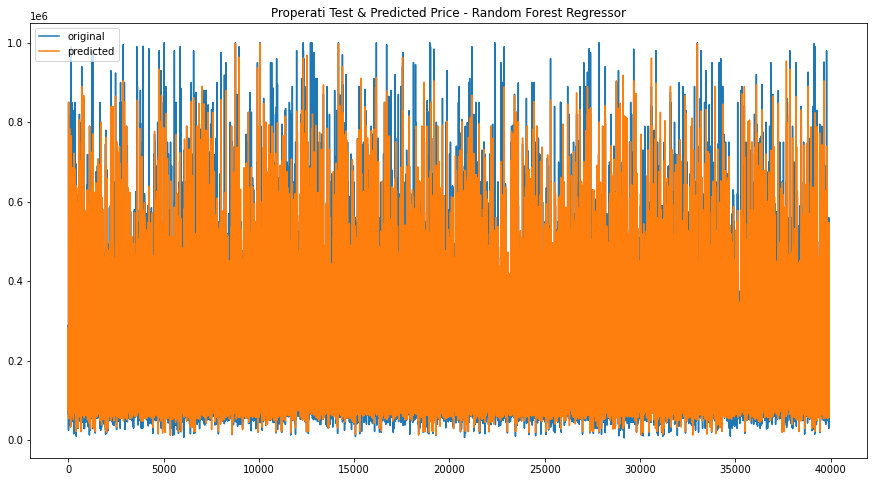

In [69]:
x_ax = range(len(y_test_rf))
plt.figure(figsize = (15,8))
plt.plot(x_ax, y_test_rf, label="original")
plt.plot(x_ax, ypred_test_rf, label="predicted")
plt.title("Properati Test & Predicted Price - Random Forest Regressor")
plt.legend()
plt.show()

Raíz del error cuadrático medio en Train: 35508.06747487542
Raíz del error cuadrático medio en Test: 54849.521392827184
R2 score Train Random Forest Regressor Optimizado : 0.93
R2 score Test Random Forest Regressor Optimizado : 0.83


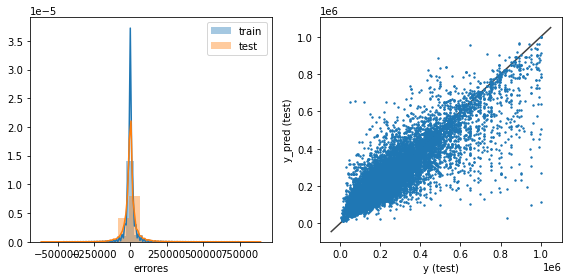

In [70]:
rmse_train_rf_optim = np.sqrt(mean_squared_error(y_train_rf, ypred_train_rf))
rmse_test_rf_optim = np.sqrt(mean_squared_error(y_test_rf, ypred_test_rf))
print(f'Raíz del error cuadrático medio en Train: {rmse_train_rf_optim}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_rf_optim}')
print("R2 score Train Random Forest Regressor Optimizado : %.2f" % r2_score(y_train_rf,ypred_train_rf))
print("R2 score Test Random Forest Regressor Optimizado : %.2f" % r2_score(y_test_rf,ypred_test_rf))

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train_rf - ypred_train_rf, bins = 20, label = 'train')
sns.distplot(y_test_rf - ypred_test_rf, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test_rf,ypred_test_rf, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

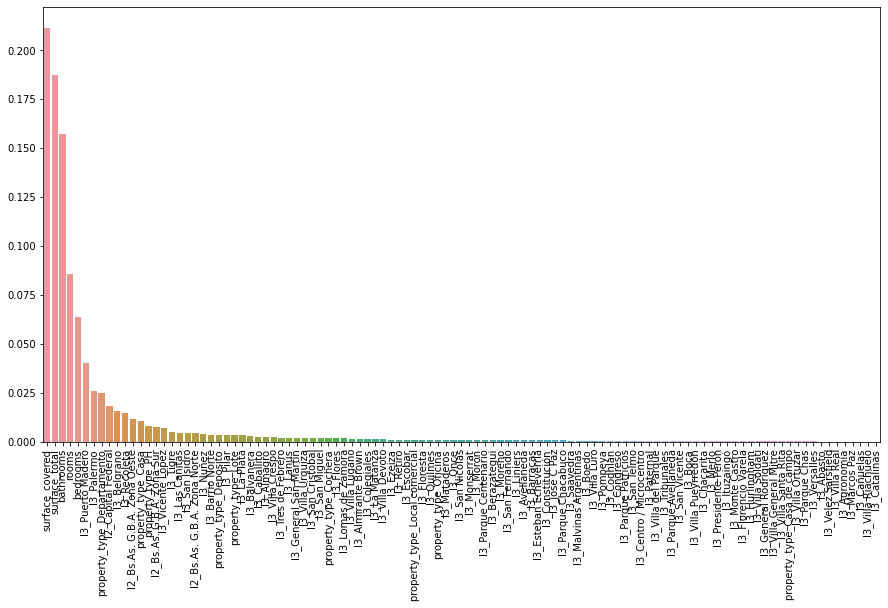

In [71]:
importances_optim = properati_rf_optim.feature_importances_
columns = X_train_rf.columns
indices = np.argsort(importances_optim)[::-1]

plt.figure(figsize = (15,8))
plt.xticks(rotation = 90)
sns.barplot(columns[indices], importances_optim[indices])
plt.show()

<span style="color:orange"> XGBOOST REGRESSOR </span>

Elijo probar como segundo modelo XGBoost en su modalidad Regresor. El Boosting es una técnica en la que se agregan nuevos modelos para corregir los errores cometidos por los modelos existentes. Los modelos se agregan secuencialmente hasta que no quede ningún error para eliminar. En el caso de XGBoost se llama Gradient Boost porque utiliza un algoritmo de descenso de gradiente para minimizar la pérdida al agregar nuevos modelos.

En este caso no voy a realizar una optimización de hiperparámetros, para no extender demasiado el notebook.

In [72]:
import xgboost as xgb

xtrain_xgb, xtest_xgb, ytrain_xgb, ytest_xgb=train_test_split(X_rf, y_rf, test_size=0.30)

In [73]:
xgbr = xgb.XGBRegressor(n_estimators = 50, max_depth = 47) 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=47,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


In [74]:
from sklearn.model_selection import RandomizedSearchCV
model = xgbr
param_grid = {'n_estimators': np.arange(1,100), 'max_depth': np.arange (1,100), 'random_state': np.arange (1,100)}
grid_search = RandomizedSearchCV(model, param_grid, n_jobs = 1, cv = 2, n_iter = 33)
grid_search.fit(X_rf,y_rf)
print(grid_search.best_params_)

{'random_state': 46, 'n_estimators': 97, 'max_depth': 13}


Entreno el modelo

In [75]:
 xgbr.fit(xtrain_xgb, ytrain_xgb)   

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=47,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Evalúo el modelo

In [76]:
score = xgbr.score(xtrain_xgb, ytrain_xgb)  
print("Training score: ", score)

Training score:  0.9431272506432627


In [77]:
scores = cross_val_score(xgbr, xtrain_xgb, ytrain_xgb,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.79


In [78]:
kfold = KFold(n_splits=5, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain_xgb, ytrain_xgb, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.79


In [79]:
ypred_test_xgb = xgbr.predict(xtest_xgb)
ypred_train_xgb = xgbr.predict(xtrain_xgb )
mse = mean_squared_error(ytest_xgb, ypred_test_xgb)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 3411233946.71
RMSE: 58405.77


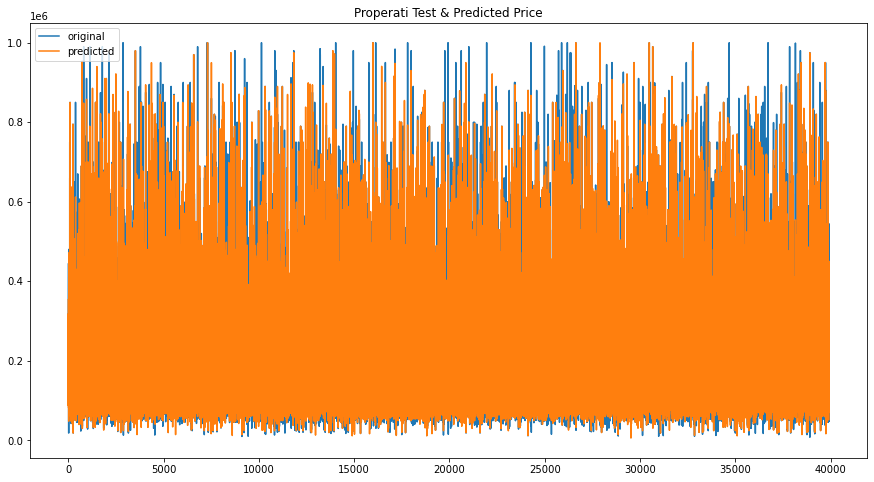

In [80]:
x_ax = range(len(ytest_xgb))
plt.figure(figsize = (15,8))
plt.plot(x_ax, ytest_xgb, label="original")
plt.plot(x_ax, ypred_test_xgb, label="predicted")
plt.title("Properati Test & Predicted Price")
plt.legend()
plt.show()

Raíz del error cuadrático medio en Train: 31576.26511274421
Raíz del error cuadrático medio en Test: 58405.769806687
R2 score XG Boost Train : 0.94
R2 score XG Boost Test : 0.81


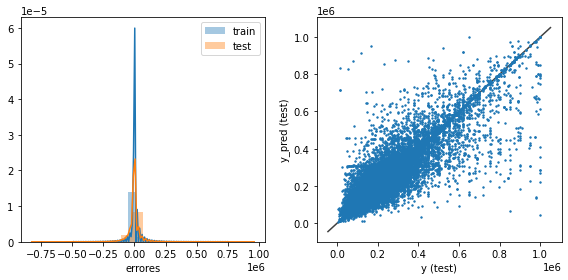

In [81]:
rmse_train_xgb = np.sqrt(mean_squared_error(ytrain_xgb, ypred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(ytest_xgb, ypred_test_xgb))
print(f'Raíz del error cuadrático medio en Train: {rmse_train_xgb}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_xgb}')
print("R2 score XG Boost Train : %.2f" % r2_score(ytrain_xgb,ypred_train_xgb))
print("R2 score XG Boost Test : %.2f" % r2_score(ytest_xgb,ypred_test_xgb))

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(ytrain_xgb - ypred_train_xgb, bins = 20, label = 'train')
sns.distplot(ytest_xgb - ypred_test_xgb, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(ytest_xgb, ypred_test_xgb, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

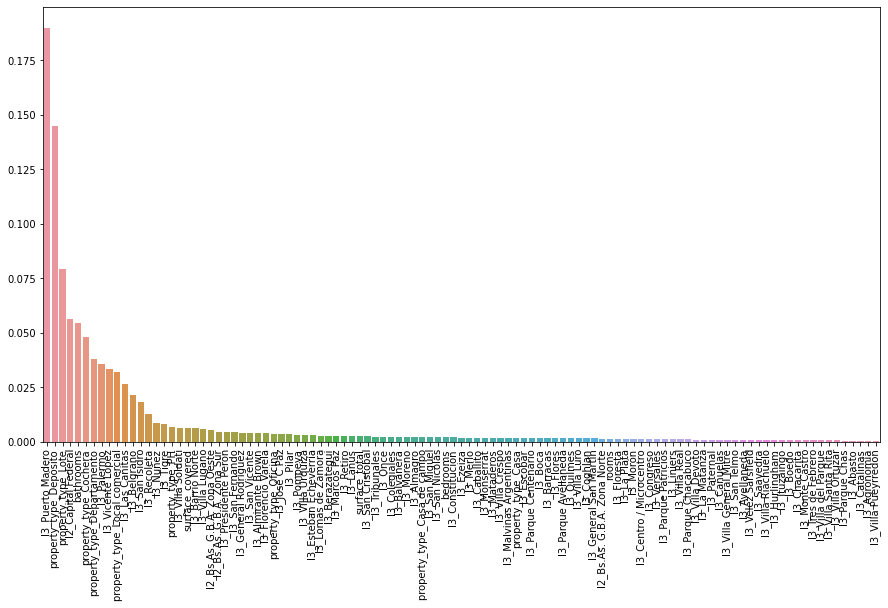

In [82]:
importances_xgb = xgbr.feature_importances_
columns_xgb= xtrain_xgb.columns
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize = (15,8))
plt.xticks(rotation = 90)
sns.barplot(columns_xgb[indices_xgb], importances_xgb[indices_xgb])
plt.show()

**Modelo Elegido:** Comparando los modelos no ensamblados de la parte 1, Random Forest Regressor y XGBoost, optaría por este último. Mi elección se centra en que el modelo tiene buenos resultados (casi los mismos que el Random Forest optimizado, pero sin optimizar).  

Por otro lado en el análisis de los features que principalemente consideran los modelos, XGBoost le da más peso a la zona del inmueble, lo cual es acorde a como se maneja el mercado inmobiliario. 

<span style="color:orange"> C - **Interpretación de Modelos** </span>


Intento responder las preguntas planteadas en esta fase de la entrega, sobre el modelo que elegí, es decir XGBoost.

**-¿Qué variables fueron relevantes para el modelo para hacer una predicción?**

Como se puede ver en el gráfico XGBoost le otorga un peso más relevante a ciertas ubicaciones o tipos de propiedad. 

**¿Cuáles no?**

En el análisis de feature importances no aparecen la cantidad de dormitorios (bedrooms).

**Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué?**

Con la siguiente función es posible imprimir las diferentes iteraciones del XGBoost y ver que peso tienen en cada una los diferentes features. También es posible ver como va descendiendo el RMSE tanto en train como en test en cada 'árbol'.


In [83]:
def MyCallback():
    def callback(env):
        print(env.model.get_score(importance_type='weight'))
    return callback

dtrain = xgb.DMatrix(xtrain_xgb, label=ytrain_xgb)
dtest = xgb.DMatrix(xtest_xgb, label=ytest_xgb)

params = {'objective':'reg:squarederror', 'eval_metric': 'rmse'}

bst = xgb.train(params, dtrain, num_boost_round=5, evals=[(dtrain, 'train'), (dtest, 'test')],
        callbacks=[MyCallback()])

{'bathrooms': 3, 'surface_total': 10, 'l2_Capital Federal': 5, 'surface_covered': 15, 'l3_Vicente López': 3, 'l3_Palermo': 7, 'l2_Bs.As. G.B.A. Zona Norte': 2, 'property_type_Departamento': 2, 'property_type_Depósito': 1, 'l3_Moreno': 1, 'l3_Puerto Madero': 4, 'rooms': 4, 'l3_Recoleta': 1, 'l3_Belgrano': 1, 'l3_San Isidro': 1}
[0]	train-rmse:175260.56250	test-rmse:175233.07812
{'bathrooms': 5, 'surface_total': 21, 'l2_Capital Federal': 10, 'surface_covered': 29, 'l3_Vicente López': 3, 'l3_Palermo': 13, 'l2_Bs.As. G.B.A. Zona Norte': 2, 'property_type_Departamento': 6, 'property_type_Depósito': 2, 'l3_Moreno': 1, 'l3_Puerto Madero': 8, 'rooms': 6, 'l3_Recoleta': 3, 'l3_Belgrano': 4, 'l3_San Isidro': 2, 'l3_Tigre': 1, 'property_type_Casa': 1, 'bedrooms': 3}
[1]	train-rmse:135653.43750	test-rmse:135790.98438
{'bathrooms': 7, 'surface_total': 41, 'l2_Capital Federal': 13, 'surface_covered': 39, 'l3_Vicente López': 5, 'l3_Palermo': 15, 'l2_Bs.As. G.B.A. Zona Norte': 3, 'property_type_Depart

**Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?**

XGBoost se adaptó mucho más a mi idea inicial con el dataset. En el primer proyecto no tenía los skills para hacerlo pero ya veía que la ubicación y los tipos de propiedad eran importantes en la definición del precio. 

<span style="color:orange"> DESAFIO OPCIONAL </span>

Aplica una técnica de Clustering sobre el dataset que anteriormente había normalizado mediante PCA.

Opto por clusterizar el data set mediante KMeans. Primero realizo la búsqueda de la cantidad de clústers a encontrar mediante la técnica Elbow (codo). 

Uso el dataset que ya atravesó el escalado de datos. 

In [84]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

In [137]:
data_km = pd.concat([data_prop_noprice, data_prop_1[['price']]], axis=1)


In [138]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
Sum_of_squared_distances = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
K = np.arange(2,40)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(data_km)
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,data_km.shape[0])
    Sum_of_squared_distances.append(distancia_media)

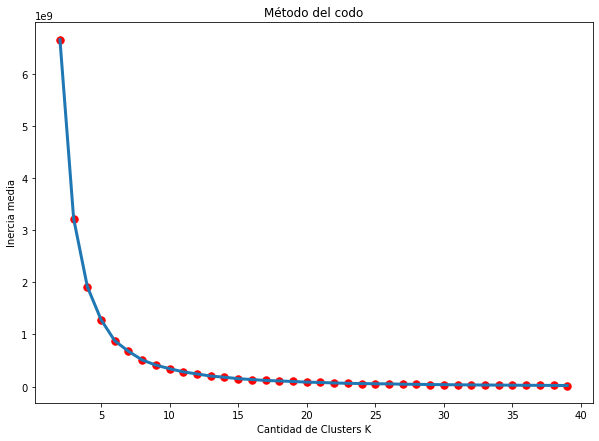

In [139]:
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo')
plt.show()

In [167]:
# Defino y entreno el modelo
km = KMeans(n_clusters=5, max_iter = 300, init = 'k-means++', n_init = 10)
km = km.fit(data_km)

In [168]:
# Sumo la etiqueta de los clústers resultantes al dataset
data_km ['Kmeans_cluster'] = km.labels_
data_km.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,property_type_Depósito,...,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,price,Kmeans_cluster
1,-0.782661,-0.860003,0.896478,-0.455862,-0.083667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,159000.0,0
2,-0.782661,-0.860003,-0.713027,-0.680272,-0.121073,0,0,0,0,0,...,0,0,0,0,0,0,0,0,125000.0,2
3,-0.782661,-0.860003,-0.713027,-0.321217,-0.106686,0,0,0,0,0,...,0,0,0,0,0,0,0,0,295000.0,3
4,-0.782661,-0.860003,-0.713027,-0.635390,-0.149847,0,0,0,0,0,...,0,0,0,0,0,0,0,0,40000.0,2
5,-0.782661,-0.860003,-0.713027,-0.581532,-0.089422,0,0,0,0,0,...,0,0,0,0,0,0,0,0,150000.0,0


In [169]:
centroides, etiquetas = km.cluster_centers_ , km.labels_

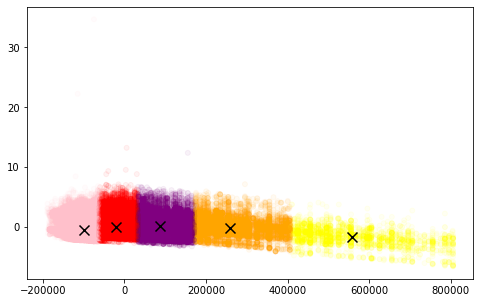

In [178]:
# Se aplica la reducción de dimensionalidad a los datos
from sklearn.decomposition import PCA
modelo_pca = PCA(n_components = 2)
modelo_pca.fit(data_km)
pca = modelo_pca.transform(data_km)

#Se aplicar la reducción de dimsensionalidad a los centroides
centroides_pca = modelo_pca.transform(centroides)

# Se define los colores de cada clúster
colores = ['red','orange', 'pink', 'purple', 'yellow']
#Se asignan los colores a cada clústeres
colores_cluster = [colores[etiquetas[i]] for i in range(len(pca))]

#Se grafica los componentes PCA

plt.figure(figsize = (8,5))

plt.scatter(pca[:, 0], pca[:, 1], c = colores_cluster, 
            marker = '.', s = 100, alpha = 0.05)

#Se grafican los centroides

plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
            marker = 'x', s = 100, linewidths = 5, c = 'black')

#Se guadan los datos en una variable para que sea fácil escribir el código
xvector = modelo_pca.components_[0] * max(pca[:,0])
yvector = modelo_pca.components_[1] * max(pca[:,1])
columnas = data_km.columns

plt.show()

Se puede observar que la separación que realizó K-means es conforme al gráfico de precios (ver para referencia proyección 3D de los datos en la fase de preprocesamiento).

<span style="color:orange"> METOLOGIA. MEJORAS. </span>


En la construcción del proyecto encontré algunos puntos que me gustaría ir mejorando sucesivamente:

1- Preprocesamiento de los datos: me cuesta recortar el dataset. Es algo que también me pasa en mi actividad laboral (donde trabajo con cantidades masivas de datos). Fortalecer el entendimiento de la distribución de las variables mediante una mejor exploración de los datos (pairplot, boxplot, heatmap) me parece el mejor camino para sentir seguridad en la elección de los datos útiles para los modelos. 

2- Uso de los soportes gráficos: aún tengo dificultades para decidir qué aspectos reforzar con un gráfico, y de qué tipo. 

3- Evaluación de modelos: tengo oportunidad de profundizar las conclusiones provenientes de la evaluación de los modelos (revisar las diferencias entre train y test por ejemplo, entender cuando es apropiada o cuando debería mejorarla). También creo que la experiencia me puede acercar a otros métodos de evaluación que me den una perspectiva más completa y segura de los modelos aplicados. 

4- En este segundo proyecto aún me queda abierto el espacio de aplicación concreto de los modelos, convertirlos en una solución, trabajar con nueva información (por ejemplo ingresar caracterísiticas de inmuebles no incluídos en el dataset y ver el modelo en acción). Aún me resulta más teórico que práctico.

También atravesé espacios de crecimiento y mejora respecto del primer proyecto:

5- En esta entrega logré mucha seguridad en la construcción de soluciones por mi misma. La metodología fue leer la documentación, foros, ver tutoriales. Por ejemplo respecto de XGBoost hay solo información en los foros específicos y fue más difícil de interpretar qué era lo útil para mi proyecto, además de readaptar líneas de código, gráficos. Esto fue un aprendizaje que ya estoy capitalizando en el siguiente proyecto a entregar e incluso en algunas soluciones para mi trabajo. 

Leí los artículos sobre método que me incluiste en la corrección del proyecto y me resultaron sumamente útiles. Entiendo mejor (más allá del checklist y la consigna específica) cómo presentar mi trabajo como científica de datos. Procuraré aplicar esta estructura metodológica de manera más prolija en los proyectos 3 y 4.

Muchas gracias!

Carolina Degiorgio.